In [181]:
import pandas as pd
df = pd.read_csv("data_1.csv", encoding='latin-1')
df.drop(['country','continent','location','alert','net'], axis = 1, inplace= True)

# Convert 'date_time' to datetime objects
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract the year
df['Year'] = df['date_time'].dt.year

# Add earthquake_id column
df['earthquake_id'] = range(1, len(df) + 1)

df.head()

<ipython-input-181-bfd489143982>:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])


title  magnitude           date_time  \
0           M 6.5 - 42 km W of Sola, Vanuatu        6.5 2023-08-16 12:47:00   
1  M 6.5 - 43 km S of IntipucÃ¡, El Salvador        6.5 2023-07-19 00:22:00   
2  M 6.6 - 25 km ESE of LoncopuÃ©, Argentina        6.6 2023-07-17 03:05:00   
3      M 7.2 - 98 km S of Sand Point, Alaska        7.2 2023-07-16 06:48:00   
4                   M 7.3 - Alaska Peninsula        7.3 2023-07-16 06:48:00   

   cdi  mmi  tsunami  sig  nst      dmin    gap magType    depth  latitude  \
0    7    4        0  657  114  7.177000   25.0     mww  192.955  -13.8814   
1    8    6        0  775   92  0.679000   40.0     mww   69.727   12.8140   
2    7    5        0  899   70  1.634000   28.0     mww  171.371  -38.1911   
3    6    6        1  860  173  0.907000   36.0     mww   32.571   54.3844   
4    0    5        1  820   79  0.879451  172.8      Mi   21.000   54.4900   

   longitude  Year  earthquake_id  
0   167.1580  2023              1  
1   -88.1265  2023              2  
2   -70.3731  2023              3  
3  -160.6990  2023              4  
4  -160.7960  2023              5

In [182]:
df['magType'].unique()

array(['mww', 'Mi', 'mwc', 'mwb', 'ml', 'mw', 'ms', 'mb', 'md'],
      dtype=object)

In [183]:
# Define conversion functions
def convert_to_mw(magnitude, mag_type):
    if mag_type == 'mw' or mag_type in ['mww', 'mwb', 'mwc']:
        return magnitude
    elif mag_type == 'ml':
        return 0.67 * magnitude + 1.46
    elif mag_type == 'ms':
        return 0.67 * magnitude + 2.07
    elif mag_type == 'mb':
        return 1.27 * magnitude - 0.18
    elif mag_type == 'md':
        return 0.8 * magnitude + 1.2
    elif mag_type == 'Mi':
        # Assuming a generic adjustment factor for Mi
        return magnitude + 1.0  # Adjust based on region-specific data
    else:
        return None  # Unknown magType

# Apply conversion
df['mw'] = df.apply(lambda row: convert_to_mw(row['magnitude'], row['magType']), axis=1)

In [184]:
df_1 = df.copy

# Applying clustering based on Density using DBSCAN

In [185]:
latitude = df['latitude']
longitude = df['longitude']
coordinates = df[['latitude', 'longitude']]

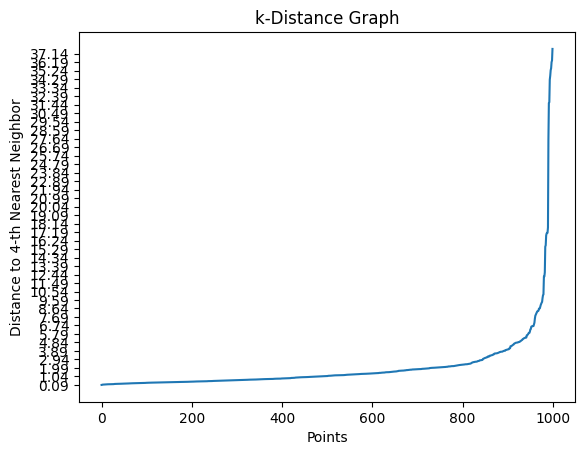

In [186]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

k = 4  # min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(coordinates)
distances, indices = neighbors_fit.kneighbors(coordinates)

# Sort the distances in increasing order and plot the graph
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to {}-th Nearest Neighbor'.format(k))
plt.title('k-Distance Graph')

# Adjust y-axis ticks for granularity
plt.yticks(np.arange(min(distances), max(distances), 0.95))



plt.show()

In [187]:
data = df.copy()

In [188]:
from sklearn.cluster import KMeans
import pandas as pd
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

coordinates = data[['latitude', 'longitude']].to_numpy()

# Using DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=4, metric='haversine')  # 'haversine' for spherical distances
clusters = dbscan.fit_predict(np.radians(coordinates))
data['cluster'] = clusters
print(data['cluster'].value_counts())

cluster
 0     648
 1     187
 3      30
 2      27
-1      23
 6      16
 4      15
 5      12
 11     11
 7       8
 8       7
 9       7
 12      5
 10      4
Name: count, dtype: int64


In [189]:
import folium
from folium.plugins import MarkerCluster

center_lat = data['latitude'].mean()
center_lon = data['longitude'].mean()

# Initializing the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Creating a color map for the clusters
import matplotlib.cm as cm
import matplotlib.colors as colors

n_clusters = data['cluster'].nunique()
colormap = cm.get_cmap('tab10', n_clusters)  # Choosing a colormap
cluster_colors = {cluster: colors.rgb2hex(colormap(cluster)) for cluster in data['cluster'].unique()}

# Adding markers to the map
for _, row in data.iterrows():
    cluster = row['cluster']
    if cluster == -1:  # Handling noise points separately (gray color)
        color = '#808080'
    else:
        color = cluster_colors[cluster]

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {cluster}"
    ).add_to(m)

m

<ipython-input-189-7d8178d99d58>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', n_clusters)  # Choosing a colormap


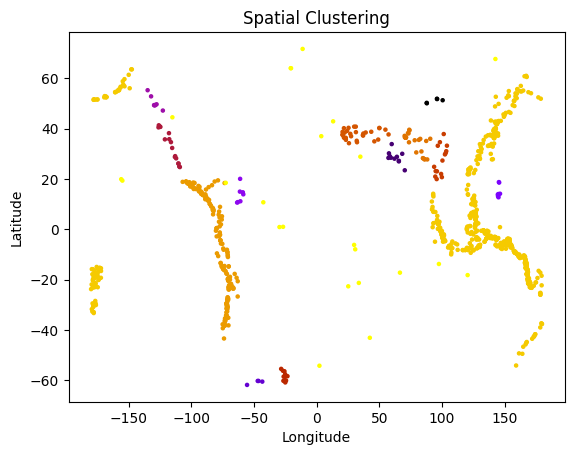

In [190]:
import matplotlib.pyplot as plt
plt.scatter(data['longitude'], data['latitude'], c=data['cluster'],cmap='gnuplot_r', s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Clustering')
plt.show()

In [191]:
outliers = data[data['cluster']== -1 ]
outliers.head()

title  magnitude           date_time  cdi  \
102    M 6.7 - Mauritius - Reunion region        6.7 2021-05-12 14:05:00    9   
120    M 6.9 - central Mid-Atlantic Ridge        6.9 2020-09-18 21:43:00    0   
123    M 6.5 - central Mid-Atlantic Ridge        6.5 2020-08-30 21:20:00    4   
139                M 6.5 - Stanley, Idaho        6.5 2020-03-31 23:52:00    8   
158  M 6.6 - 200km W of Broome, Australia        6.6 2019-07-14 05:39:00    5   

     mmi  tsunami   sig  nst    dmin   gap magType  depth  latitude  \
102    3        0   694    0  10.669  45.0     mww  10.00  -17.2495   
120    3        1   732    0  11.255  16.0     mww  10.00    0.9604   
123    5        0   651    0  15.394  31.0     mww  10.00    0.8696   
139    8        0  1410    0   0.885  31.0     mww  12.06   44.4646   
158    5        0   791    0   2.978  32.0     mww  10.00  -18.2242   

     longitude  Year  earthquake_id   mw  cluster  
102    66.3745  2021            103  6.7       -1  
120   -26.8332  2020            121  6.9       -1  
123   -29.7046  2020            124  6.5       -1  
139  -115.1180  2020            140  6.5       -1  
158   120.3580  2019            159  6.6       -1

In [192]:
data.drop(outliers.index, inplace=True)
df = data.copy()
df.head()

title  magnitude           date_time  \
0           M 6.5 - 42 km W of Sola, Vanuatu        6.5 2023-08-16 12:47:00   
1  M 6.5 - 43 km S of IntipucÃ¡, El Salvador        6.5 2023-07-19 00:22:00   
2  M 6.6 - 25 km ESE of LoncopuÃ©, Argentina        6.6 2023-07-17 03:05:00   
3      M 7.2 - 98 km S of Sand Point, Alaska        7.2 2023-07-16 06:48:00   
4                   M 7.3 - Alaska Peninsula        7.3 2023-07-16 06:48:00   

   cdi  mmi  tsunami  sig  nst      dmin    gap magType    depth  latitude  \
0    7    4        0  657  114  7.177000   25.0     mww  192.955  -13.8814   
1    8    6        0  775   92  0.679000   40.0     mww   69.727   12.8140   
2    7    5        0  899   70  1.634000   28.0     mww  171.371  -38.1911   
3    6    6        1  860  173  0.907000   36.0     mww   32.571   54.3844   
4    0    5        1  820   79  0.879451  172.8      Mi   21.000   54.4900   

   longitude  Year  earthquake_id   mw  cluster  
0   167.1580  2023              1  6.5        0  
1   -88.1265  2023              2  6.5        1  
2   -70.3731  2023              3  6.6        1  
3  -160.6990  2023              4  7.2        0  
4  -160.7960  2023              5  8.3        0

# EDA

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 0 to 999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          977 non-null    object        
 1   magnitude      977 non-null    float64       
 2   date_time      977 non-null    datetime64[ns]
 3   cdi            977 non-null    int64         
 4   mmi            977 non-null    int64         
 5   tsunami        977 non-null    int64         
 6   sig            977 non-null    int64         
 7   nst            977 non-null    int64         
 8   dmin           977 non-null    float64       
 9   gap            977 non-null    float64       
 10  magType        977 non-null    object        
 11  depth          977 non-null    float64       
 12  latitude       977 non-null    float64       
 13  longitude      977 non-null    float64       
 14  Year           977 non-null    int32         
 15  earthquake_id  977 non-null 

In [194]:
df.describe()

magnitude                      date_time         cdi         mmi  \
count  977.000000                            977  977.000000  977.000000   
mean     6.944678  2010-06-09 00:09:55.332651264    3.607984    6.011259   
min      6.500000            1995-05-05 03:53:00    0.000000    1.000000   
25%      6.600000            2003-08-21 12:12:00    0.000000    5.000000   
50%      6.800000            2011-05-10 08:55:00    4.000000    6.000000   
75%      7.100000            2017-01-10 06:13:00    7.000000    7.000000   
max      9.100000            2023-08-16 12:47:00    9.000000   10.000000   
std      0.439674                            NaN    3.323238    1.410905   

          tsunami          sig         nst        dmin         gap  \
count  977.000000   977.000000  977.000000  977.000000  977.000000   
mean     0.326510   845.010235  193.879222    1.072994   20.697738   
min      0.000000   650.000000    0.000000    0.000000    0.000000   
25%      0.000000   691.000000    0.000000    0.000000    0.000000   
50%      0.000000   745.000000    0.000000    0.000000   18.000000   
75%      1.000000   873.000000  402.000000    1.529000   27.000000   
max      1.000000  2910.000000  934.000000   12.896000  239.000000   
std      0.469176   294.777090  239.144462    1.896978   23.649034   

            depth    latitude   longitude         Year  earthquake_id  \
count  977.000000  977.000000  977.000000   977.000000     977.000000   
mean    76.035301    4.124749   52.707062  2009.931423     501.566018   
min      2.700000  -61.848400 -179.968000  1995.000000       1.000000   
25%     16.100000  -13.481000  -71.799000  2003.000000     255.000000   
50%     30.000000   -2.520000  118.631000  2011.000000     502.000000   
75%     56.000000   24.696000  149.487000  2017.000000     750.000000   
max    670.810000   63.514400  179.662000  2023.000000    1000.000000   
std    132.005582   26.372357  118.032626     8.244124     288.632917   

               mw    cluster  
count  977.000000  977.00000  
mean     6.955096    0.96520  
min      5.815000    0.00000  
25%      6.600000    0.00000  
50%      6.800000    0.00000  
75%      7.200000    1.00000  
max      9.100000   12.00000  
std      0.450876    2.17776

In [195]:
df.head()

title  magnitude           date_time  \
0           M 6.5 - 42 km W of Sola, Vanuatu        6.5 2023-08-16 12:47:00   
1  M 6.5 - 43 km S of IntipucÃ¡, El Salvador        6.5 2023-07-19 00:22:00   
2  M 6.6 - 25 km ESE of LoncopuÃ©, Argentina        6.6 2023-07-17 03:05:00   
3      M 7.2 - 98 km S of Sand Point, Alaska        7.2 2023-07-16 06:48:00   
4                   M 7.3 - Alaska Peninsula        7.3 2023-07-16 06:48:00   

   cdi  mmi  tsunami  sig  nst      dmin    gap magType    depth  latitude  \
0    7    4        0  657  114  7.177000   25.0     mww  192.955  -13.8814   
1    8    6        0  775   92  0.679000   40.0     mww   69.727   12.8140   
2    7    5        0  899   70  1.634000   28.0     mww  171.371  -38.1911   
3    6    6        1  860  173  0.907000   36.0     mww   32.571   54.3844   
4    0    5        1  820   79  0.879451  172.8      Mi   21.000   54.4900   

   longitude  Year  earthquake_id   mw  cluster  
0   167.1580  2023              1  6.5        0  
1   -88.1265  2023              2  6.5        1  
2   -70.3731  2023              3  6.6        1  
3  -160.6990  2023              4  7.2        0  
4  -160.7960  2023              5  8.3        0

## Univariate Analysis

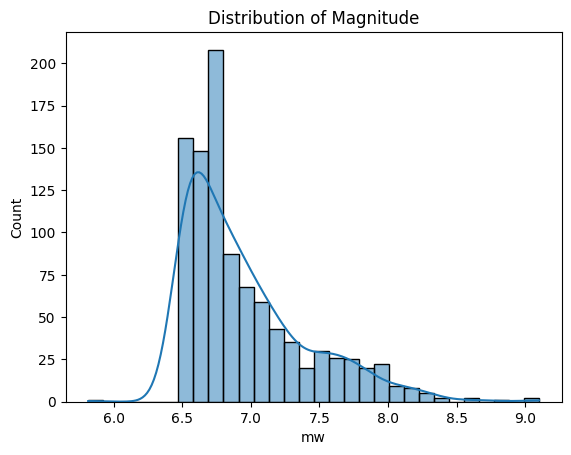

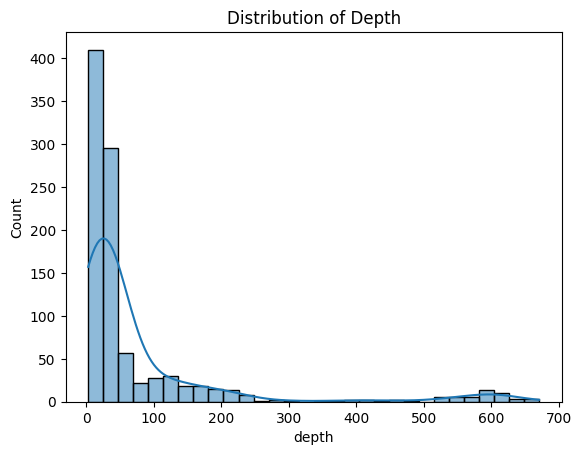

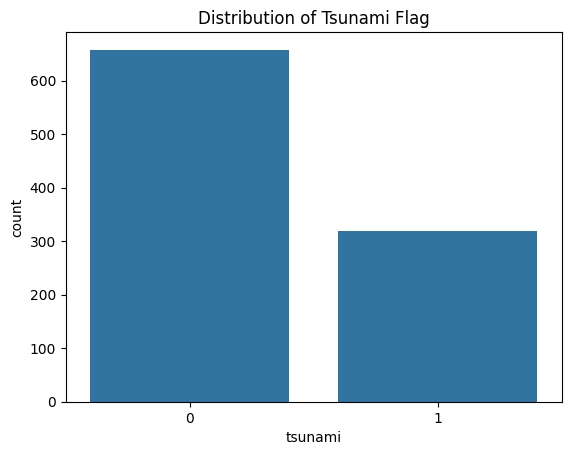

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Magnitude
sns.histplot(df['mw'], kde=True, bins=30)
plt.title('Distribution of Magnitude')
plt.show()

# Distribution of Depth
sns.histplot(df['depth'], kde=True, bins=30)
plt.title('Distribution of Depth')
plt.show()

# Distribution of Tsunami Flag
sns.countplot(x='tsunami', data=df)
plt.title('Distribution of Tsunami Flag')
plt.show()

## Bivariate Aanlysis

In [197]:
df_c = data.copy()
df_c.drop(['title', 'magnitude','date_time','magType','earthquake_id','latitude','longitude'], axis=1, inplace=True)

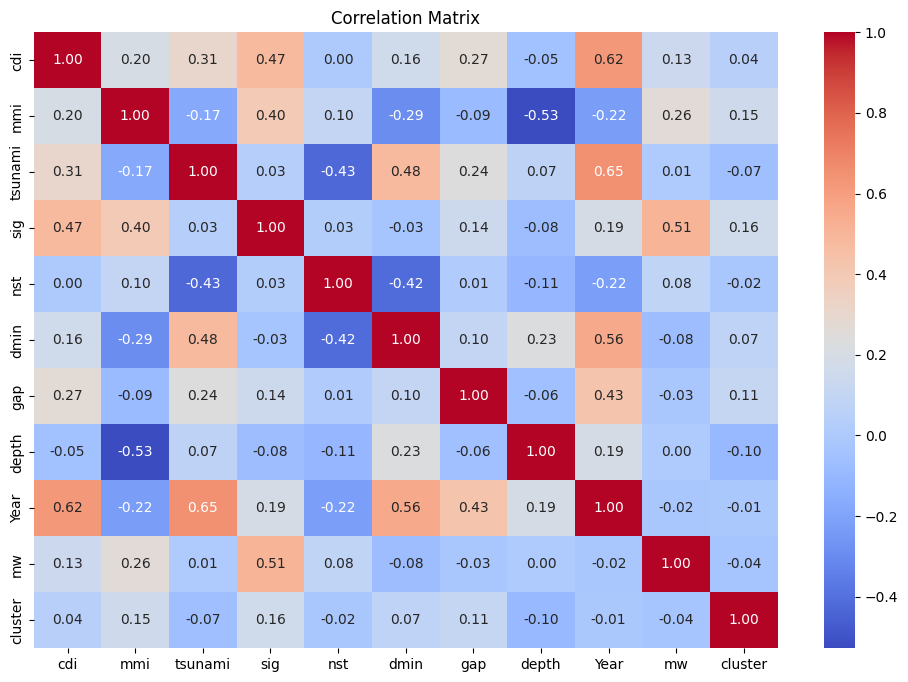

In [198]:
# Compute correlation matrix
correlation_matrix = df_c.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

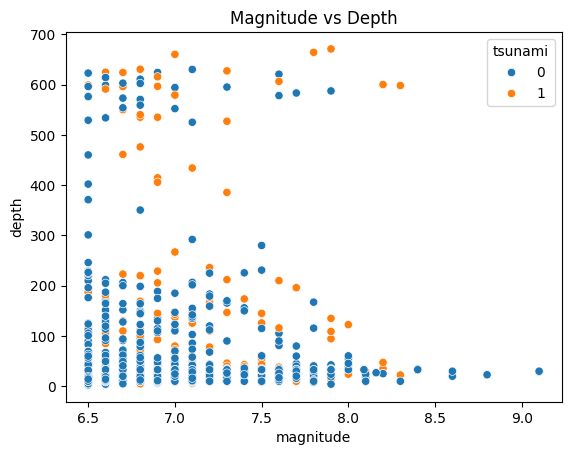

In [199]:
# Magnitude vs Depth
sns.scatterplot(x='magnitude', y='depth', hue='tsunami', data=df)
plt.title('Magnitude vs Depth')
plt.show()

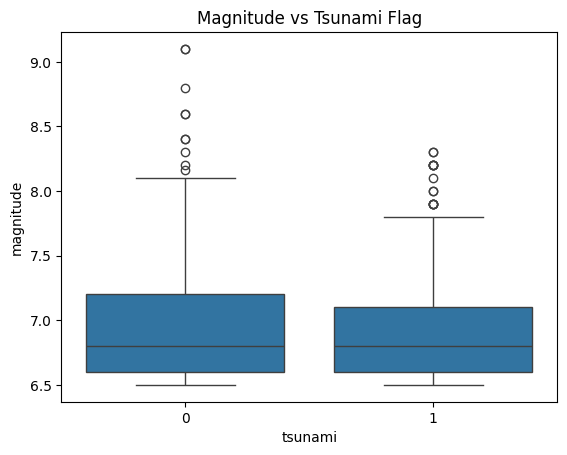

In [200]:
# Boxplot of Magnitude for Tsunami Flag
sns.boxplot(x='tsunami', y='magnitude', data=df)
plt.title('Magnitude vs Tsunami Flag')
plt.show()

## Correlation

In [201]:
from scipy.stats import spearmanr

# Compute correlation for numeric features
numeric_features = ['magnitude', 'depth', 'mmi', 'sig', 'dmin','cluster']
correlations = {}

for feature in numeric_features:
    corr, _ = spearmanr(df[feature], df['tsunami'])
    correlations[feature] = corr

# Display correlations
print("Spearman Correlations with Tsunami Flag:")
for key, value in correlations.items():
    print(f"{key}: {value:.3f}")

Spearman Correlations with Tsunami Flag:
magnitude: 0.016
depth: 0.007
mmi: -0.170
sig: 0.055
dmin: 0.672
cluster: -0.090


In [202]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

numeric_features = ['magnitude', 'depth', 'mmi', 'sig', 'dmin','cluster']
correlations = {}


if df['tsunami'].dtype != 'int' and df['tsunami'].dtype != 'bool':
    df['tsunami'] = LabelEncoder().fit_transform(df['tsunami'])

for feature in numeric_features:
    corr, _ = chi2(df[[feature]], df['tsunami'])  # Reshape feature to 2D
    correlations[feature] = corr[0]  # chi2 returns a numpy array

# Display correlations
print("Chi-Square Scores with Tsunami Flag:")
for key, value in correlations.items():
    print(f"{key}: {value:.3f}")


Chi-Square Scores with Tsunami Flag:
magnitude: 0.000
depth: 1110.868
mmi: 9.470
sig: 122.546
dmin: 753.028
cluster: 20.311


In [203]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

# Encode categorical data
le = LabelEncoder()
df['magnitude_type_encoded'] = le.fit_transform(df['magType'])

# Chi-Square Test
chi2_features, p_values = chi2(df[['magnitude_type_encoded']], df['tsunami'])

# Display results
print(f"Chi-Square Scores: {chi2_features}")
print(f"P-Values: {p_values}")


Chi-Square Scores: [23.54782086]
P-Values: [1.21847347e-06]


In [204]:
df_xyz= df.copy()
df_xyz.drop(['title', 'date_time','Year','latitude','longitude','earthquake_id'], axis=1, inplace=True)

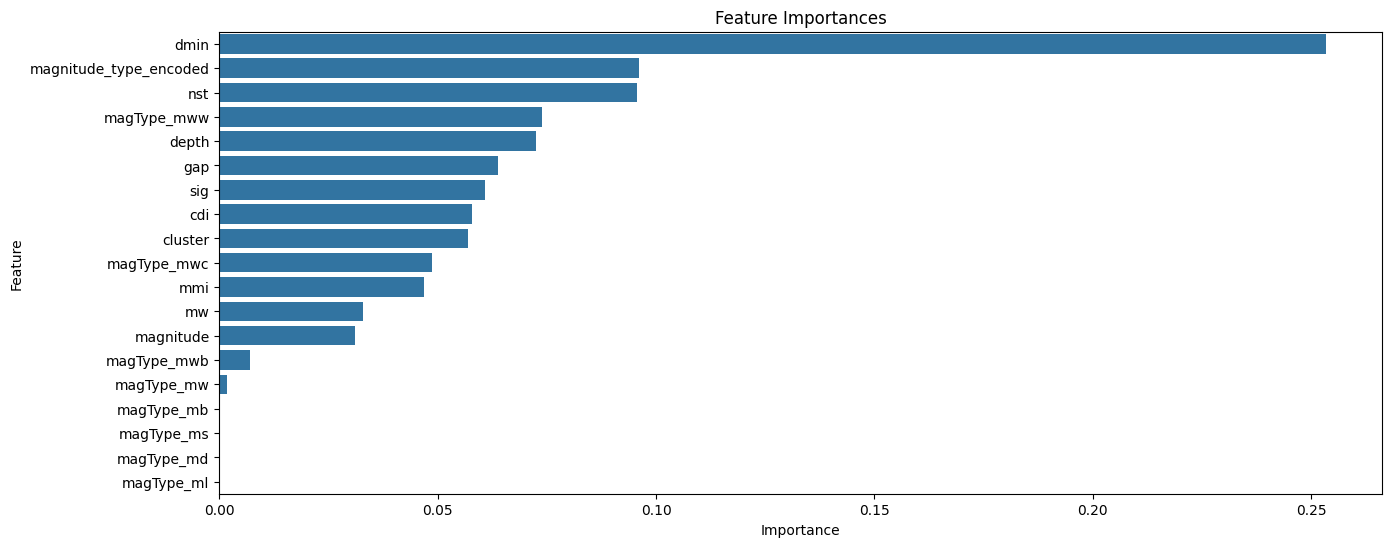

In [205]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data
X = df_xyz.drop(['tsunami'], axis=1)  # Exclude target
y = df['tsunami']

# Handle categorical and missing values if required
X = pd.get_dummies(X, drop_first=True)

# Fit a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(15, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


In [206]:
X

magnitude  cdi  mmi  sig  nst      dmin    gap    depth   mw  cluster  \
0          6.5    7    4  657  114  7.177000   25.0  192.955  6.5        0   
1          6.5    8    6  775   92  0.679000   40.0   69.727  6.5        1   
2          6.6    7    5  899   70  1.634000   28.0  171.371  6.6        1   
3          7.2    6    6  860  173  0.907000   36.0   32.571  7.2        0   
4          7.3    0    5  820   79  0.879451  172.8   21.000  8.3        0   
..         ...  ...  ...  ...  ...       ...    ...      ...  ...      ...   
995        7.1    0    9  776    0  0.000000    0.0   11.000  7.1        0   
996        7.7    0    4  912    0  0.000000    0.0   20.200  7.7        0   
997        6.9    0    6  732    0  0.000000    0.0   11.200  6.9        0   
998        6.6    0    9  670    0  0.000000    0.0   14.000  6.6        3   
999        7.1    0    7  776    0  0.000000    0.0   16.000  7.1        0   

     magnitude_type_encoded  magType_mb  magType_md  magType_ml  magType_ms  \
0                         8       False       False       False       False   
1                         8       False       False       False       False   
2                         8       False       False       False       False   
3                         8       False       False       False       False   
4                         0       False       False       False       False   
..                      ...         ...         ...         ...         ...   
995                       6       False       False       False       False   
996                       5       False       False       False       False   
997                       5       False       False       False       False   
998                       5       False       False       False       False   
999                       5       False       False       False       False   

     magType_mw  magType_mwb  magType_mwc  magType_mww  
0         False        False        False         True  
1         False        False        False         True  
2         False        False        False         True  
3         False        False        False         True  
4         False        False        False        False  
..          ...          ...          ...          ...  
995       False         True        False        False  
996        True        False        False        False  
997        True        False        False        False  
998        True        False        False        False  
999        True        False        False        False  

[977 rows x 19 columns]

In [207]:
df_xyz= data.copy()
df_xyz.drop(['title', 'date_time','Year','latitude','longitude','earthquake_id','magType'], axis=1, inplace=True)

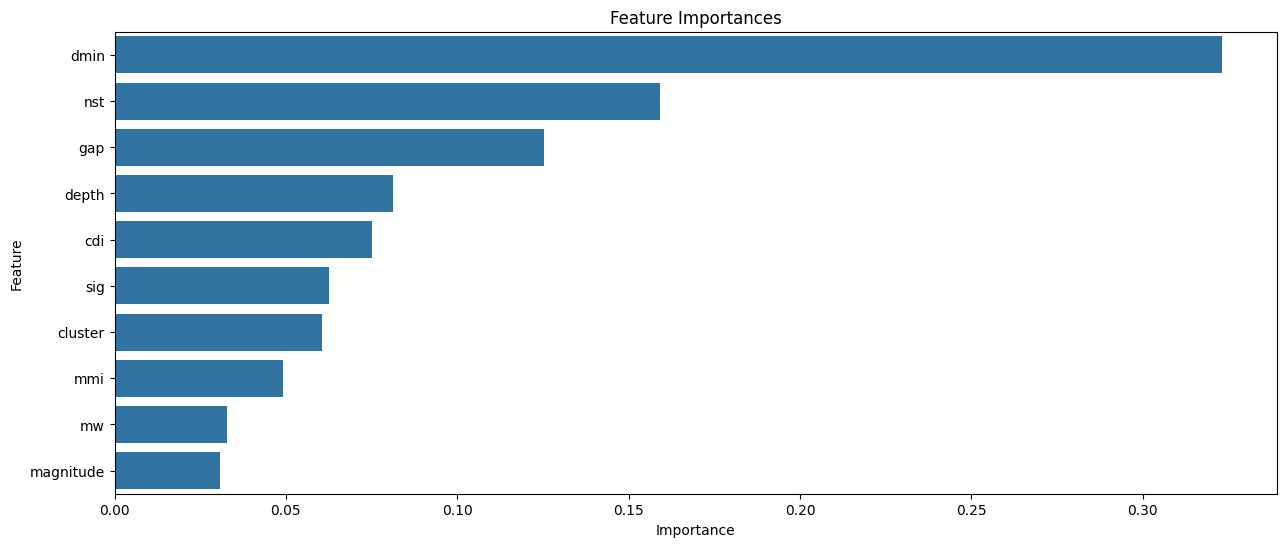

In [208]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data
X = df_xyz.drop(['tsunami'], axis=1)  # Exclude target
y = df['tsunami']

# Handle categorical and missing values if required
X = pd.get_dummies(X, drop_first=True)

# Fit a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(15, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


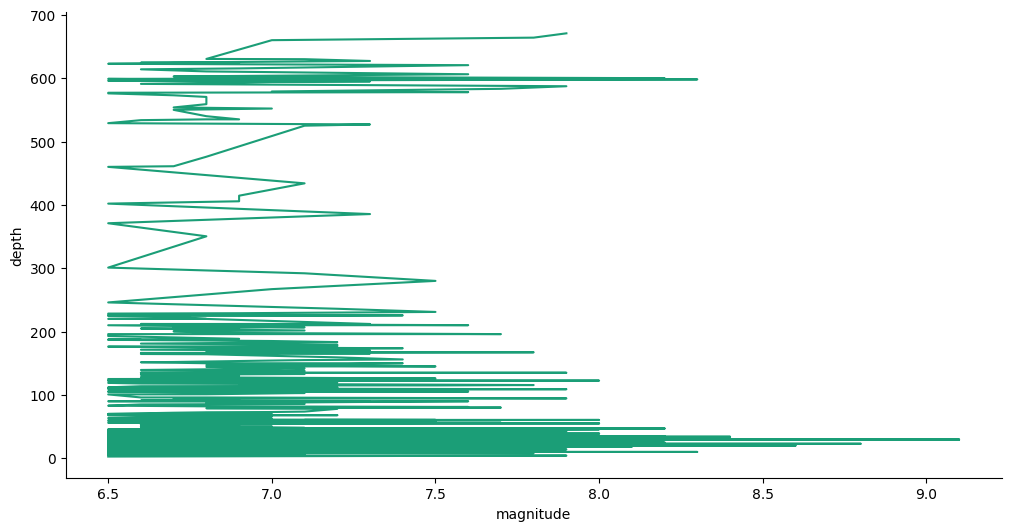

In [209]:
# earthquake_id vs magnitude

import matplotlib.pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['magnitude']
  ys = series['depth']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('depth', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('magnitude')
_ = plt.ylabel('depth')

# Classifying the region in high, medium and low risk zones

In [210]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap

def analyze_clusters(df):
    """
    Extract features from pre-clustered earthquake data while keeping individual points
    """
    # Calculate cluster-level features
    cluster_features = df.groupby('cluster').agg({
        'depth': ['median', 'mean', 'std'],
        'magnitude': ['median', 'mean', 'std', 'max']
    }).reset_index()

    # Flatten multi-level columns
    cluster_features.columns = ['cluster', 'median_depth', 'mean_depth', 'std_depth',
                              'median_magnitude', 'mean_magnitude', 'std_magnitude',
                              'max_magnitude']

    # Calculate frequency features
    five_years_ago = pd.to_datetime(df['date_time']).max() - pd.Timedelta(days=5*365)

    freq_features = []
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        dates = pd.to_datetime(cluster_data['date_time'])

        total_cluster_points = len(cluster_data)
        earthquakes_last_5years = len(cluster_data[dates >= five_years_ago])
        ratio_5years = earthquakes_last_5years / total_cluster_points if total_cluster_points else 0  # Avoid division by zero

        freq_features.append({
            'cluster': cluster,
            'freq_5years': len(cluster_data[dates >= five_years_ago]),
            'freq_major_5years': len(cluster_data[(dates >= five_years_ago) &
                                                (cluster_data['magnitude'] > 6)]),
            'ratio_5years' : ratio_5years
        })

    freq_df = pd.DataFrame(freq_features)

    # Merge all features
    cluster_features = cluster_features.merge(freq_df, on='cluster')

    return cluster_features

def classify_risks(features_df):
    """
    Classify clusters into risk zones based on combined risk factors
    """
    # Calculate risk score
    features_df['risk_score'] = (
        features_df['median_magnitude'] *
        features_df['freq_5years'] *
        np.log1p(features_df['freq_major_5years'] + 1)
    )

    # Classify into risk zones
    features_df['risk_zone'] = pd.qcut(
        features_df['risk_score'],
        q=3,
        labels=['Low', 'Medium', 'High']
    )

    return features_df

def visualize_points(df, cluster_risks):
    """
    Create interactive map showing all individual points colored by their cluster's risk level
    """
    # Merge risk zones back to original data
    df_with_risks = df.merge(
        cluster_risks[['cluster', 'risk_zone', 'risk_score']],
        on='cluster'
    )

    # Create base map
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Add different layers for each risk level
    colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}

    # Create feature groups for each risk level
    risk_layers = {
        risk: folium.FeatureGroup(name=f'{risk} Risk')
        for risk in colors.keys()
    }

    # Add points to appropriate layers
    for idx, row in df_with_risks.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3 + row['magnitude']/2,  # Size based on magnitude
            color=colors[row['risk_zone']],
            fill=True,
            popup=f"""
                <b>Earthquake Details</b><br>
                Date: {row['date_time']}<br>
                Magnitude: {row['magnitude']:.1f}<br>
                Depth: {row['depth']:.1f}<br>
                Risk Zone: {row['risk_zone']}<br>
                Cluster: {row['cluster']}
            """,
            opacity=0.7,
            fill_opacity=0.5
        ).add_to(risk_layers[row['risk_zone']])

    # Add heatmap layer
    heat_data = df_with_risks[['latitude', 'longitude', 'magnitude']].values.tolist()
    HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(
        folium.FeatureGroup(name='Heatmap')
    )

    # Add all layers to map
    for layer in risk_layers.values():
        layer.add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    return m

def analyze_and_visualize(df):
    """
    Complete pipeline for analysis and visualization
    """
    # Extract cluster features
    cluster_features = analyze_clusters(df)

    # Classify risks
    cluster_features = classify_risks(cluster_features)

    # Create visualization
    risk_map = visualize_points(df, cluster_features)

    return risk_map, cluster_features

In [211]:
risk_map, cluster_features = analyze_and_visualize(df)

In [212]:
risk_map

In [213]:
print("\nCluster Risk Distribution:")
print(cluster_features['risk_zone'].value_counts())


Cluster Risk Distribution:
risk_zone
Medium    5
Low       4
High      4
Name: count, dtype: int64


# Training an XGBoost gradient classifer to predict laebls for Tsunami risks

In [214]:
# Use this to drop rows where 'cluster' is -1:
data.drop(data[data['cluster'] == -1].index, inplace=True)

In [215]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd


# Encode categorical variables if needed
le = LabelEncoder()
if 'magnitude_type' in df.columns:
    data['magnitude_type_encoded'] = le.fit_transform(data['magType'])
    data = data.drop('magType', axis=1)

# Separate features and target
X = data.drop(['tsunami','date_time'], axis=1)  # Exclude the target
y = data['tsunami']

# One-hot encode categorical features and standardize
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [216]:
X_scaled

array([[-1.0118987 ,  1.02121892, -1.42624033, ..., -0.33390168,
        -0.70764967,  0.99693408],
       [-1.0118987 ,  1.32228437, -0.00798404, ..., -0.33390168,
        -0.70764967,  0.99693408],
       [-0.78434086,  1.02121892, -0.71711219, ..., -0.33390168,
        -0.70764967,  0.99693408],
       ...,
       [-0.10166735, -1.0862392 , -0.00798404, ..., -0.33390168,
        -0.70764967, -1.00307535],
       [-0.78434086, -1.0862392 ,  2.11940039, ..., -0.33390168,
        -0.70764967, -1.00307535],
       [ 0.35344833, -1.0862392 ,  0.7011441 , ..., -0.33390168,
        -0.70764967, -1.00307535]])

In [217]:
import pandas as pd

# Convert categorical columns into numeric using one-hot encoding or label encoding
from sklearn.preprocessing import LabelEncoder

# Columns to encode
categorical_columns = ['magType','cluster']  # Example categorical columns

# Apply Label Encoding or One-Hot Encoding
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])


In [218]:
#removing unecessary columns

data.drop(['earthquake_id','title', 'latitude', 'longitude','date_time','magnitude','magType'],axis=1, inplace= True)

In [219]:
data

cdi  mmi  tsunami  sig  nst      dmin    gap    depth  Year   mw  cluster
0      7    4        0  657  114  7.177000   25.0  192.955  2023  6.5        0
1      8    6        0  775   92  0.679000   40.0   69.727  2023  6.5        1
2      7    5        0  899   70  1.634000   28.0  171.371  2023  6.6        1
3      6    6        1  860  173  0.907000   36.0   32.571  2023  7.2        0
4      0    5        1  820   79  0.879451  172.8   21.000  2023  8.3        0
..   ...  ...      ...  ...  ...       ...    ...      ...   ...  ...      ...
995    0    9        0  776    0  0.000000    0.0   11.000  1995  7.1        0
996    0    4        0  912    0  0.000000    0.0   20.200  1995  7.7        0
997    0    6        0  732    0  0.000000    0.0   11.200  1995  6.9        0
998    0    9        0  670    0  0.000000    0.0   14.000  1995  6.6        3
999    0    7        0  776    0  0.000000    0.0   16.000  1995  7.1        0

[977 rows x 11 columns]

In [220]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [221]:
X_train

array([[ 0.12589049, -1.0862392 ,  0.7011441 , ...,  2.99489361,
        -0.70764967, -1.00307535],
       [-1.0118987 ,  1.02121892,  0.7011441 , ..., -0.33390168,
        -0.70764967,  0.99693408],
       [-0.78434086,  1.02121892,  0.7011441 , ..., -0.33390168,
        -0.70764967,  0.99693408],
       ...,
       [-1.0118987 ,  1.62334981,  1.41027225, ..., -0.33390168,
        -0.70764967,  0.99693408],
       [-0.32922519, -1.0862392 , -0.71711219, ..., -0.33390168,
         1.41312863, -1.00307535],
       [-1.0118987 ,  1.02121892, -0.00798404, ...,  2.99489361,
        -0.70764967, -1.00307535]])

In [222]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_prob_xgb):.2f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:24:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       132
           1       0.87      0.92      0.89        64

    accuracy                           0.93       196
   macro avg       0.91      0.93      0.92       196
weighted avg       0.93      0.93      0.93       196

AUC-ROC Score: 0.96


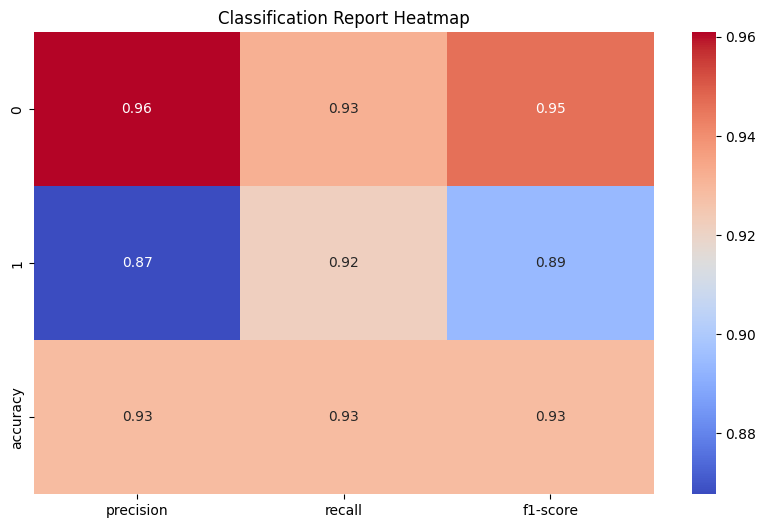

In [223]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

report_str = classification_report(y_test, y_pred_xgb, output_dict=True)
report_df = pd.DataFrame(report_str).transpose()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-2, :].drop(columns=['support']), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

In [224]:
report_df

precision    recall  f1-score     support
0              0.960938  0.931818  0.946154  132.000000
1              0.867647  0.921875  0.893939   64.000000
accuracy       0.928571  0.928571  0.928571    0.928571
macro avg      0.914292  0.926847  0.920047  196.000000
weighted avg   0.930475  0.928571  0.929104  196.000000

In [229]:
import keras
import tensorflow as tf

# Prepare data for neural network
X = data.drop(['tsunami'], axis=1)
y = data['tsunami']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model with improvements
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)), # Increased neurons
    keras.layers.Dropout(0.2), # Added dropout for regularization
    keras.layers.BatchNormalization(), # Added batch normalization
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2), # Added dropout
    keras.layers.BatchNormalization(), # Added batch normalization
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with improved optimizer and learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001) # Adjust learning rate as needed
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with increased epochs and validation data and callbacks
model.fit(X_train_scaled, y_train, epochs=150, batch_size=34, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Further evaluation metrics
print(classification_report(y_test, y_pred))

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5739 - loss: 0.7908 - val_accuracy: 0.8608 - val_loss: 0.4621
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.4641 - val_accuracy: 0.8734 - val_loss: 0.4476
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.4135 - val_accuracy: 0.8734 - val_loss: 0.4349
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8515 - loss: 0.3568 - val_accuracy: 0.8734 - val_loss: 0.4108
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8553 - loss: 0.3720 - val_accuracy: 0.8734 - val_loss: 0.3996
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8874 - loss: 0.3059 - val_accuracy: 0.8861 - val_loss: 0.3753
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8668 - loss: 0.3173 - val_accuracy: 0.8861 - val_loss: 0.3565
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8635 - loss: 0.3095 - val_accuracy: 0.8861 - val_loss: 0.

In [230]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy}")


accuracy = accuracy_score(y_test, y_pred)
print(f"Neural Network Accuracy: {accuracy}")

XGBoost Accuracy: 0.9285714285714286
Neural Network Accuracy: 0.8928571428571429


# So in our case XGBoost is performing well than a Sequential ANN